In [64]:
import ase
import time
import sys
import torch
from torch.nn import MSELoss
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Checkpoint, EpochScoring
from skorch.callbacks.lr_scheduler import LRScheduler
from amp.descriptor.gaussian import Gaussian
from amptorch.gaussian import SNN_Gaussian
from amptorch.model import FullNN, CustomLoss
from amptorch.data_preprocess import AtomsDataset, factorize_data, collate_amp, TestDataset
from md_work.md_utils import md_run, calculate_energies, calculate_forces, time_plots, kde_plots, calculate_rmse
from amptorch.skorch_model import AMP
from amptorch.skorch_model.utils import target_extractor, energy_score, forces_score
from amptorch.exp_repulsive import lj_optim
from amptorch.lj_12_6 import lj_optim as lj_optim_12_6
from amptorch.morse import lj_optim as lj_morse
from torch.utils.data import DataLoader
from torch.nn import init, ReLU
from skorch.utils import to_numpy
import numpy as np
from ase import Atoms, units
from ase.calculators.emt import EMT
import seaborn as sns
import skorch.callbacks.base

%matplotlib inline

In [65]:
def parity_plots(x, y, xlabel, ylabel, title, num_atoms, dtype="energy"):
    if dtype == "energy":
        rmse = calculate_rmse(x, y, num_atoms, dtype=dtype)
        text = f"RMSE: {rmse:.6f}eV/atom"
        lims = [0, 10]
    else:
        rmse = calculate_rmse(x, y, num_atoms, dtype=dtype)
        x = np.concatenate(np.array(x))
        y = np.concatenate(np.array(y))
        text = f"RMSE: {rmse:.6f}eV/A"
        lims = [-5, 5]
    grid = sns.jointplot(y, x)
    ax = grid.ax_joint
    _ = ax.set_xlim(lims)
    _ = ax.set_ylim(lims)
    _ = ax.plot(lims, lims, '--')
    _ = ax.set_ylabel(xlabel)
    _ = ax.set_xlabel(ylabel)
    _ = ax.text(x=lims[1], y=lims[0], s=title,
                horizontalalignment='right',
                verticalalignment='bottom',
                fontsize=14)
    _ = ax.text(x=lims[0], y=lims[1], s=text,
                horizontalalignment='left',
                verticalalignment='top',
                fontsize=14)

In [66]:
# define symmetry functions to be used
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276 #EMT asap_cutoff: False

In [67]:
import pickle as pkl
# Define Training data
distances = []
energies = []
forces = []
# distances = np.linspace(1, 7, 100)
images = []

label = "bond_example"
# for displacement in distances:
#     atoms = Atoms("CuCu", [(0, 0, 0), (0, 0, displacement)])
#     atoms.set_cell([10, 10, 10])
#     atoms.wrap(pbc=True)
#     atoms.set_calculator(EMT())
#     energy = atoms.get_potential_energy(apply_constraint=False)
#     force = atoms.get_forces(apply_constraint=False)
#     energies.append(energy)
#     forces.append(force)
#     images.append(atoms)
infile_Cu = open('./delta_ml/dft/CuCu.pkl', 'rb')
data_Cu = pkl.load(infile_Cu)
infile_Cu.close()

for i in data_Cu['AtomsObj']:
    images.append(i)

for n, m in zip(data_Cu['Distance'], data_Cu['Energy']):
    distances.append(n)
    energies.append(m)

energies = np.array(energies)
# forces = np.concatenate(np.array(forces))
distances = np.array(distances)

# training_idx = np.array([6, 7, 8, 9, 10, 12, 14, 16,])
training_idx = np.array([13, 14, 16, 18, 19])
training_images = [images[i] for i in training_idx]
training_energies = energies[training_idx]
training_distances = distances[training_idx]
for image in training_images:
    print(image.get_potential_energy())

-2.48159258
-2.69485183
-2.65603048
-2.36483499
-2.18469917


In [68]:
def train(training_images, forcesonly=False, fit=False, p0=None, lj=None, method='Nelder-Mead', combo=None):
    lj_data = None
    scaling = None
    if lj is not None:
        params_dict = {"Cu": []}
        cutoff = Gs["cutoff"]
        if lj == 'rep':
            lj_model = lj_optim(images, p0, params_dict, cutoff, label, forcesonly=forcesonly)
            lj_model = lj_optim(training_images, p0, params_dict, cutoff, "test", forcesonly=forcesonly)
        elif lj == '12_6':
            lj_model = lj_optim_12_6(images, p0, params_dict, cutoff, label, forcesonly=forcesonly)
            lj_model = lj_optim_12_6(training_images, p0, params_dict, cutoff, "test", forcesonly=forcesonly)
        elif lj == 'morse':
            lj_model = lj_morse(images, p0, params_dict, cutoff, label, combo=combo)
            lj_model = lj_morse(training_images, p0, params_dict, cutoff, "test", combo=combo)
        
        if fit:
            fitted_params = lj_model.fit(method=method)
        else:
            fitted_params = p0

        lj_energies, lj_forces, num_atoms = lj_model.lj_pred(training_images, fitted_params, params_dict)
        lj_data = [lj_energies, lj_forces, num_atoms, fitted_params, params_dict, lj_model]

        lj_energy_pred, lj_force_pred, _ = lj_model.lj_pred(images, fitted_params, params_dict)
        scaling = "rel"

    forcetraining = True
    training_data = AtomsDataset(training_images, SNN_Gaussian, Gs, forcetraining=forcetraining,
            label=label, cores=4, lj_data=lj_data, scaling=scaling)
    unique_atoms = training_data.elements
    fp_length = training_data.fp_length
    device = "cpu"

    net = NeuralNetRegressor(
        module=FullNN(unique_atoms, [fp_length, 3, 20], device, forcetraining=forcetraining),
        criterion=CustomLoss,
        criterion__force_coefficient=0.04,
        optimizer=torch.optim.LBFGS,
        optimizer__line_search_fn="strong_wolfe",
        lr=1e-1,
        batch_size=len(training_data),
        max_epochs=300,
        iterator_train__collate_fn=collate_amp,
        iterator_train__shuffle=False,
        iterator_valid__collate_fn=collate_amp,
        device=device,
        train_split= 0,
        callbacks=[
            EpochScoring(
                forces_score,
                on_train=True,
                use_caching=True,
                target_extractor=target_extractor,
            ),
            EpochScoring(
                energy_score,
                on_train=True,
                use_caching=True,
                target_extractor=target_extractor,
            ), 
        ],
    )

    calc = AMP(training_data, net, label)
    calc.train()

    ml_delta_e_pred = [calc.get_potential_energy(image) for image in images]
    ml_delta_f_pred = [calc.get_forces(image) for image in images]
    for image in images:
        print(image.get_calculator())
    
    if lj is None:
        return ml_delta_e_pred, ml_delta_f_pred
    else:
        return ml_delta_e_pred, ml_delta_f_pred, lj_energy_pred, lj_force_pred, fitted_params

In [14]:
# ML Only
ml_pred, ml_forces = train(training_images)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          6.0352         24.4444      241.2971  0.0810
      2          0.2452          3.8485        2.6102  0.0856
      3          0.0215          0.4670        0.0367  0.0930
      4          0.0072          0.1139        0.0023  0.0998
      5          0.0012          0.0221        0.0001  0.1010
      6          0.0007          0.0127        0.0000  0.1073
      7          0.0007          0.0116        0.0000  0.1292
      8          0.0003          0.0035        0.0000  0.0300
      9          0.0003          0.0034        0.0000  0.0249
     10          0.0003          0.0034        0.0000  0.0221
     11          0.0003          0.0034        0.0000  0.0220
     12          0.0003          0.0034        0.0000  0.0239
     13          0.0003          0.0034        0.0000  0.0221
     14          

    127          0.0003          0.0034        0.0000  0.0220
    128          0.0003          0.0034        0.0000  0.0221
    129          0.0003          0.0034        0.0000  0.0224
    130          0.0003          0.0034        0.0000  0.0222
    131          0.0003          0.0034        0.0000  0.0221
    132          0.0003          0.0034        0.0000  0.0222
    133          0.0003          0.0034        0.0000  0.0233
    134          0.0003          0.0034        0.0000  0.0233
    135          0.0003          0.0034        0.0000  0.0234
    136          0.0003          0.0034        0.0000  0.0233
    137          0.0003          0.0034        0.0000  0.0233
    138          0.0003          0.0034        0.0000  0.0233
    139          0.0003          0.0034        0.0000  0.0233
    140          0.0003          0.0034        0.0000  0.0233
    141          0.0003          0.0034        0.0000  0.0233
    142          0.0003          0.0034        0.0000  0.0233
    143 

    260          0.0003          0.0034        0.0000  0.0223
    261          0.0003          0.0034        0.0000  0.0222
    262          0.0003          0.0034        0.0000  0.0222
    263          0.0003          0.0034        0.0000  0.0222
    264          0.0003          0.0034        0.0000  0.0222
    265          0.0003          0.0034        0.0000  0.0223
    266          0.0003          0.0034        0.0000  0.0224
    267          0.0003          0.0034        0.0000  0.0222
    268          0.0003          0.0034        0.0000  0.0224
    269          0.0003          0.0034        0.0000  0.0222
    270          0.0003          0.0034        0.0000  0.0223
    271          0.0003          0.0034        0.0000  0.0222
    272          0.0003          0.0034        0.0000  0.0220
    273          0.0003          0.0034        0.0000  0.0223
    274          0.0003          0.0034        0.0000  0.0221
    275          0.0003          0.0034        0.0000  0.0224
    276 

In [6]:
method = 'TNC'
forcesonly = False
fit = False

In [7]:
# Repulsive-exp()
p0 = [  2.168,
        3.8386,
        0.972,
        6.379,
        12
    ]

mllj_rep_pred, mllj_rep_forces, lj_test_rep, lj_test_rep_force, rep_p0 =  train(
    training_images, forcesonly=forcesonly, fit=fit, p0=p0, lj='rep', method=method
)

print(rep_p0)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1        107.7828        501.5880    86722.9844  0.0795
      2         32.8945        225.9156    12494.2510  0.0843
      3         20.0067        132.4986     4410.0103  0.0979
      4         16.6888        105.9073     2908.6785  0.1032
      5         15.0143        105.5602     2684.5874  0.1030
      6         14.9116        105.2919     2663.2427  0.1184
      7         14.4853        105.3664     2615.6228  0.1393
      8         12.9716        105.6128     2457.7031  0.1333
      9         12.2828        105.2518     2375.9412  0.1325
     10         12.1235        105.2235     2359.4312  0.1263
     11         11.9931        105.2389     2347.3713  0.1360
     12          9.3494         98.2185     1893.1448  0.1443
     13          9.3840         53.0735      802.9276  0.1190
     14          

    113          0.2354          0.6183        0.2829  0.0261
    114          0.2354          0.6183        0.2829  0.0261
    115          0.2354          0.6183        0.2829  0.0261
    116          0.2354          0.6183        0.2829  0.0262
    117          0.2354          0.6183        0.2829  0.0263
    118          0.2354          0.6183        0.2829  0.0249
    119          0.2354          0.6183        0.2829  0.0249
    120          0.2354          0.6183        0.2829  0.0250
    121          0.2354          0.6183        0.2829  0.0261
    122          0.2354          0.6183        0.2829  0.0263
    123          0.2354          0.6183        0.2829  0.0247
    124          0.2354          0.6183        0.2829  0.0249
    125          0.2354          0.6183        0.2829  0.0248
    126          0.2354          0.6183        0.2829  0.0248
    127          0.2354          0.6183        0.2829  0.0250
    128          0.2354          0.6183        0.2829  0.0248
    129 

    246          0.2354          0.6183        0.2829  0.0248
    247          0.2354          0.6183        0.2829  0.0247
    248          0.2354          0.6183        0.2829  0.0249
    249          0.2354          0.6183        0.2829  0.0248
    250          0.2354          0.6183        0.2829  0.0248
    251          0.2354          0.6183        0.2829  0.0249
    252          0.2354          0.6183        0.2829  0.0248
    253          0.2354          0.6183        0.2829  0.0247
    254          0.2354          0.6183        0.2829  0.0248
    255          0.2354          0.6183        0.2829  0.0248
    256          0.2354          0.6183        0.2829  0.0247
    257          0.2354          0.6183        0.2829  0.0248
    258          0.2354          0.6183        0.2829  0.0247
    259          0.2354          0.6183        0.2829  0.0248
    260          0.2354          0.6183        0.2829  0.0248
    261          0.2354          0.6183        0.2829  0.0248
    262 

In [ ]:
# LJ 12-6
p0 = [  1.696,
        3.8386,
        0.477,
        6.379,
    ]

mllj_12_6_pred, mllj_12_6_forces, lj_test_12_6, lj_test_12_6_force, lj_12_6_p0 =  train(
    training_images, forcesonly=forcesonly, fit=fit, p0=p0, lj='12_6', method=method
)

print(lj_12_6_p0)

In [72]:
# Morse
p0 = [  0.972,
        6.379,
        0.477,
    ]

mllj_morse_pred, mllj_morse_forces, lj_test_morse, lj_test_morse_force, lj_morse_p0 =  train(
    training_images, p0=p0, lj='morse', combo='mean', 
)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          0.6361          3.0071        1.9159  0.0698
      2          0.1025          0.6901        0.0739  0.0783
      3          0.1016          0.6747        0.0713  0.0977
      4          0.0988          0.6813        0.0708  0.1034
      5          0.0988          0.6617        0.0682  0.1120
      6          0.0851          0.4764        0.0408  0.1225
      7          0.0790          0.2316        0.0210  0.1295
      8          0.0683          0.0957        0.0126  0.1165
      9          0.0647          0.0913        0.0113  0.1422
     10          0.0584          0.0912        0.0094  0.1529
     11          0.0513          0.0743        0.0071  0.1552
     12          0.0509          0.0584        0.0068  0.1326
     13          0.0445          0.0623        0.0053  0.1502
     14          

    123          0.0000          0.0000        0.0000  0.0078
    124          0.0000          0.0000        0.0000  0.0078
    125          0.0000          0.0000        0.0000  0.0078
    126          0.0000          0.0000        0.0000  0.0079
    127          0.0000          0.0000        0.0000  0.0078
    128          0.0000          0.0000        0.0000  0.0078
    129          0.0000          0.0000        0.0000  0.0079
    130          0.0000          0.0000        0.0000  0.0078
    131          0.0000          0.0000        0.0000  0.0078
    132          0.0000          0.0000        0.0000  0.0079
    133          0.0000          0.0000        0.0000  0.0078
    134          0.0000          0.0000        0.0000  0.0078
    135          0.0000          0.0000        0.0000  0.0078
    136          0.0000          0.0000        0.0000  0.0079
    137          0.0000          0.0000        0.0000  0.0079
    138          0.0000          0.0000        0.0000  0.0078
    139 

    256          0.0000          0.0000        0.0000  0.0076
    257          0.0000          0.0000        0.0000  0.0076
    258          0.0000          0.0000        0.0000  0.0076
    259          0.0000          0.0000        0.0000  0.0076
    260          0.0000          0.0000        0.0000  0.0076
    261          0.0000          0.0000        0.0000  0.0076
    262          0.0000          0.0000        0.0000  0.0076
    263          0.0000          0.0000        0.0000  0.0076
    264          0.0000          0.0000        0.0000  0.0076
    265          0.0000          0.0000        0.0000  0.0076
    266          0.0000          0.0000        0.0000  0.0076
    267          0.0000          0.0000        0.0000  0.0076
    268          0.0000          0.0000        0.0000  0.0076
    269          0.0000          0.0000        0.0000  0.0076
    270          0.0000          0.0000        0.0000  0.0076
    271          0.0000          0.0000        0.0000  0.0076
    272 

In [73]:
for image in training_images:
    print(image.get_potential_energy())

-2.48159258
-2.69485183
-2.65603048
-2.36483499
-2.18469917


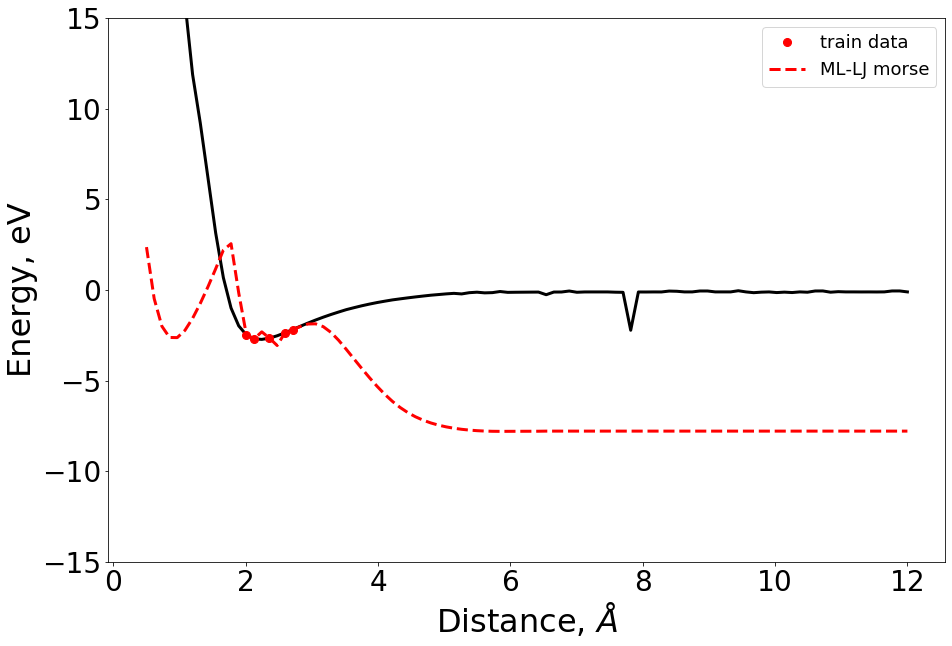

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_xlabel(r"Distance, $\AA$", fontsize=32)
ax1.set_ylabel("Energy, eV", color="k", fontsize=32)
ax1.plot(distances, energies, color="k", linewidth=3)
ax1.plot(training_distances, training_energies, "ro", label="train data", markersize=8)
# ax1.plot(distances, ml_pred, "m", label="ML", linewidth=3)
# ax1.plot(distances, mllj_rep_pred, "--g", label="ML-LJ repulsive", linewidth=3)
# ax1.plot(distances, mllj_12_6_pred, "--y", label="ML-LJ 12-6", linewidth=3)
ax1.plot(distances, mllj_morse_pred, "--r", label="ML-LJ morse", linewidth=3)
# ax1.plot(distances, lj_test_rep, "-g", label="exp-repulsive", linewidth=3)
# ax1.plot(distances, lj_test_12_6, "-y", label="LJ 12-6", linewidth=3)
# ax1.plot(distances, lj_test_morse, "-r", label="Morse", linewidth=3)
ax1.set_ylim(top=15)
ax1.set_ylim(bottom=-15)
ax1.tick_params(axis="both", labelsize=28)
plt.legend(fontsize=18)
